# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach. 

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp. 

__Sinusoidal modeling and sine tracking:__ 
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking. 

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time. 
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies. 

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid. 

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`. 

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [1]:
import numpy as np
from scipy.signal import get_window
import math
import sys, os
sys.path.append('../software/models/')
import dftModel as DFT
import utilFunctions as UF
import stft
import sineModel as SM
import IPython.display as ipd

In [2]:
# E5 - 1.1: Complete the function min_freq_est_err()

def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.
    
    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)
            
    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size
            
    """
    # analysis parameters:
    window = 'blackman'
    t = -40
    
    ### Your code here
    
    (fs, x) = UF.wavread(input_file)                                   # Read input sound
    k = 1                                                              # Initialize integer index to compute window size
    f_est = 0                                                          # Initialize estimated frequency
    while abs(f-f_est)>=0.05:                                          # Keep iterating if the frequency estimation error is larger than 0.05 Hz 
        M = 100*k + 1                                                  # Compute window size
        w = get_window(window, M)                                      # Build window
        x1 = x[int(.5*fs-((M-1)/2)) : int(.5*int(fs)+((M+1)/2))]       # Get a single frame of the signal centered at 0.5 s
        #x1 = x[.5*fs : .5*fs+M]
        nextnum = np.ceil(np.log2(M))                                  # Compute the exponent of 2 so that the FFT size is the next possible power of 2
        N = 2.0**nextnum                                               # Compute FFT size
        mX, pX = DFT.dftAnal(x1, w, int(N))                            # Compute DFT of input frame
        ploc = UF.peakDetection(mX, t)                                 # Detect the spectral peaks
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)            # Perform peak interpolation
        f_est = fs*iploc/float(N)                                      # Convert estimated frequency to Hz
        k += 1                                                         # Update index
    
    # When the frequency estimation error is less than 0.05Hz, return estimated frequency, window size and FFT size
    return (f_est, M, N)                                               


Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [3]:
# E5 - 1.2: For each of the 3 test cases, play the input sinusoid, call the function min_freq_est_err(),  
# generate sinusoid with estimated frequency value, and play it. Explain the result.

### Your code here

# TEST CASE 1
input_file1 = '../sounds/sine-490.wav'                        
(fs, x) = UF.wavread(input_file1)                                  # Read input sinusoid (TEST CASE 1)
print("Original sound - TEST CASE 1: ")
ipd.display(ipd.Audio(data=x, rate=fs))                            # Play sinusoid

(f_est, M, N) = min_freq_est_err(input_file1, f=490.0)             # Estimate sinusoid freq calling min_freq_est_err()
# Print results
print("M = ", M)
print("N = ", N)
print("f_est = ", f_est)
print("Frequency estimation error is ", abs(490.0-f_est))

A = max(x)                                                         # Sinusoid amplitude
y = A*np.cos(2*np.pi*f_est*np.arange(len(x))/float(fs))            # Generate sinusoid with estimated frequency
print("Synthetic sound - TEST CASE 1: ")
ipd.display(ipd.Audio(data=y, rate=fs))                            # Play resultant sinusoid

# TEST CASE 2
input_file2 = '../sounds/sine-1000.wav'
(fs, x) = UF.wavread(input_file2)                                  # Read input sinusoid (TEST CASE 2)
print("Original sound - TEST CASE 2: ")
ipd.display(ipd.Audio(data=x, rate=fs))                            # Play sinusoid

(f_est, M, N) = min_freq_est_err(input_file2, f=1000.0)            # Estimate sinusoid freq calling min_freq_est_err()
# Print results
print("M = ", M)
print("N = ", N)
print("f_est = ", f_est)
print("Frequency estimation error is ", abs(1000.0-f_est))

A = max(x)                                                         # Sinusoid amplitude
y = A*np.cos(2*np.pi*f_est*np.arange(len(x))/float(fs))            # Generate sinusoid with estimated frequency
print("Synthetic sound - TEST CASE 2: ")
ipd.display(ipd.Audio(data=y, rate=fs))                            # Play resultant sinusoid

# TEST CASE 3
input_file3 = '../sounds/sine-200.wav'
(fs, x) = UF.wavread(input_file3)                                  # Read input sinusoid (TEST CASE 3)
print("Original sound - TEST CASE 3: ")
ipd.display(ipd.Audio(data=x, rate=fs))                            # Play sinusoid

(f_est, M, N) = min_freq_est_err(input_file3, f=200.0)             # Estimate sinusoid freq calling min_freq_est_err()
# Print results
print("M = ", M)
print("N = ", N)
print("f_est = ", f_est)
print("Frequency estimation error is ", abs(200.0-f_est))

A = max(x)                                                         # Sinusoid amplitude
y = A*np.cos(2*np.pi*f_est*np.arange(len(x))/float(fs))            # Generate sinusoid with estimated frequency
print("Synthetic sound - TEST CASE 3: ")
ipd.display(ipd.Audio(data=y, rate=fs))                            # Play resultant sinusoid


""" Explanation
The resultant synthetized sinusoids are perceptually undistinguishable from the original 
sound for the three test cases. This matches the theory (Buser, Zwicker), which indicates that 
the smallest pitch variation that the human ear can perceive would be: 
- For 490 Hz: 0.0035*490 = 1.715 Hz
- For 1000 Hz: 0.0035*1000 = 3.5 Hz
- For 200 Hz: 0.0035*200 = 0.7 Hz
All the frequency estimation errors are above those limits. 
"""


Original sound - TEST CASE 1: 


M =  1101
N =  2048.0
f_est =  [489.96301833]
Frequency estimation error is  [0.03698167]
Synthetic sound - TEST CASE 1: 


Original sound - TEST CASE 2: 


M =  1101
N =  2048.0
f_est =  [1000.01994268]
Frequency estimation error is  [0.01994268]
Synthetic sound - TEST CASE 2: 


Original sound - TEST CASE 3: 


M =  1201
N =  2048.0
f_est =  [200.03811968]
Frequency estimation error is  [0.03811968]
Synthetic sound - TEST CASE 3: 


' Explanation\nThe resultant synthetized sinusoids are perceptually undistinguishable from the original \nsound for the three test cases. This matches the theory (Buser, Zwicker), which indicates that \nthe smallest pitch variation that the human ear can perceive would be: \n- For 490 Hz: 0.0035*490 = 1.715 Hz\n- For 1000 Hz: 0.0035*1000 = 3.5 Hz\n- For 200 Hz: 0.0035*200 = 0.7 Hz\nAll the frequency estimation errors are above those limits. \n'

## Part 2 - Tracking a two component chirp 

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`. 

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz. 

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`. 

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. 

In [4]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given sound duration.
    
    Args:
        xlen (float): duration of sound in seconds
        M (int): window size
        fs (int): sampling rate 
        H (int): hop size
        
    Result:
        np.array: time stamps
        
    """
    hM1 = int(np.floor((M+1)/2))                     
    hM2 = int(np.floor(M/2))                         
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1                                     
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"
    
    Args: 
        tStamps (np.array): time stamps
        
    Result:
        np.array: time stamps and frequency values of predefined chirp
        
    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"
    
    Args: 
        tStamps (np.array): time stamps
        
    Result:
        np.array: time stamps and frequency values of predefined chirp
        
    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound
    
    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples
           
   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component
           
    """
  
    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation
    
    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20                                 
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)        
    
    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values. 

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

Mean Error:  [ 13.66932655 528.53338713]


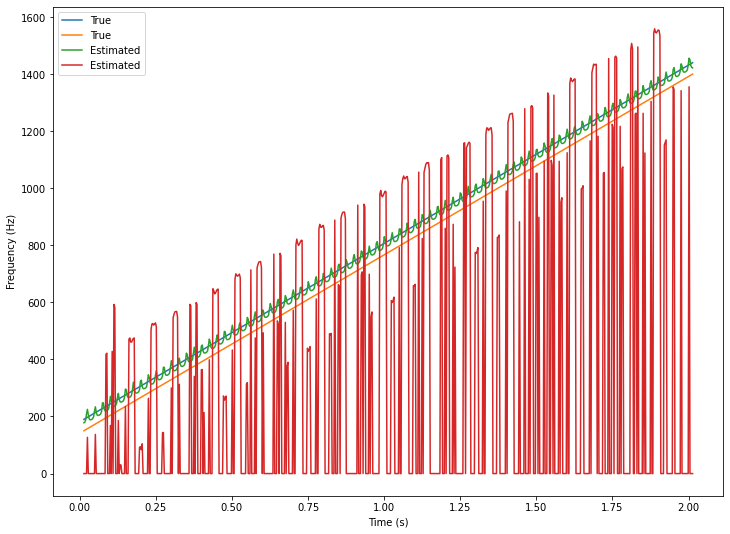

M =  3351 Mean Error:  [0.94159146 1.89742298]


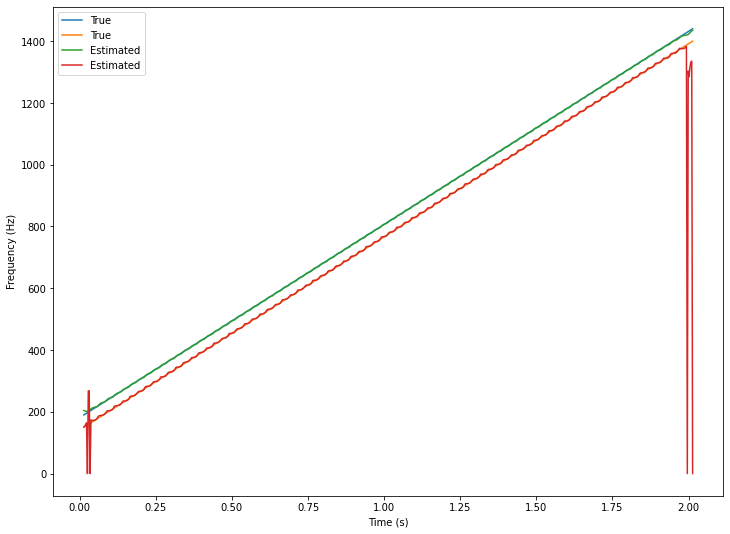

' Explanation\nBecause this is a chirp sound, that is, a time varying frequency signal, we need good time \nresolution to be able to track the changing frequency with time. However, we also need to be \nable to distinguish between the two sinusoids with a mean error lower than 2 Hz for each of \nthem. Therefore, the window size should be of an intermediate value, which allows us to have \na trade-off between both time and frequency resolution. I first selected a value of 3001 and \nkept iterating increasing 50 units the size of the window until the mean error for both \nfrequency components was lower than 2 Hz, which was found for a value of 3301. I finally selected \n3351 as the window size, which produced a better mean estimation error of 0.94 Hz and 1.90 Hz \nfor the two sinusoids. As we can see in the last plot, the higher frequency component is \nvery accurately tracked from the beginning to the end of the sound, and for the lower \nfrequency component there is a bit of confusion 

In [5]:
# E5 - 2.1: First call function freq_tracker_error() with the test case values and plot the true versus the 
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new 
# estimated frequency values. Explain the choice and result.

import matplotlib.pyplot as plt

H = 128 
window = 'blackman'
t = -80
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file) 
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)

### Your code here

# Test case
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M=1023)    # Track frequency values using sinusoidal model 
print("Mean Error: ", meanErr)                                                           # Print resultant mean error

# Plot true vs. estimated frequency values
plt.figure(figsize=(12,9))
plt.plot(tStamps, fTrackTrue, label='True')
plt.plot(tStamps, fTrackEst, label='Estimated')
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

# Tuning the window size
#M = 3001
#while (meanErr[0] >= 2) or (meanErr[1] >= 2):
#    meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
#    print("M = ", M, "Mean Error: ", meanErr)
#    M += 50

M = 3351                                                                                 # Selected window size
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)         # Track frequency values using sinusoidal model
print("M = ", M, "Mean Error: ", meanErr)                                                # Print resultant mean error

# Plot true vs. estimated frequency values
plt.figure(figsize=(12,9))
plt.plot(tStamps, fTrackTrue, label='True')
plt.plot(tStamps, fTrackEst, label='Estimated')
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

""" Explanation
Because this is a chirp sound, that is, a time varying frequency signal, we need good time 
resolution to be able to track the changing frequency with time. However, we also need to be 
able to distinguish between the two sinusoids with a mean error lower than 2 Hz for each of 
them. Therefore, the window size should be of an intermediate value, which allows us to have 
a trade-off between both time and frequency resolution. I first selected a value of 3001 and 
kept iterating increasing 50 units the size of the window until the mean error for both 
frequency components was lower than 2 Hz, which was found for a value of 3301. I finally selected 
3351 as the window size, which produced a better mean estimation error of 0.94 Hz and 1.90 Hz 
for the two sinusoids. As we can see in the last plot, the higher frequency component is 
very accurately tracked from the beginning to the end of the sound, and for the lower 
frequency component there is a bit of confusion in the beginning and end and also a bit of 
fluctuation during the central part of the sound, but the mean estimation error is still 
below 2 Hz as desired.

"""

## Part 3 -Tracking sinusoids of different amplitudes 

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`. 

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`. 

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`. 

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid. 

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz. 


Mean Error:  [ 0.19603701 29.51140815]


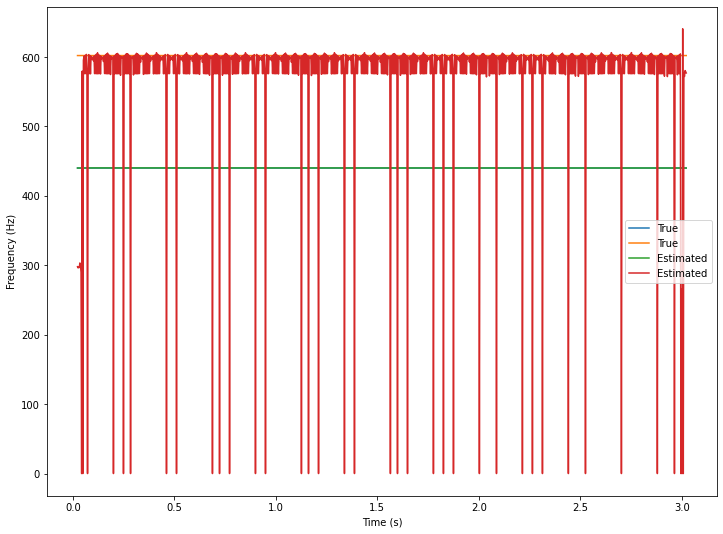

Mean Error:  [0.03843794 0.06193923]


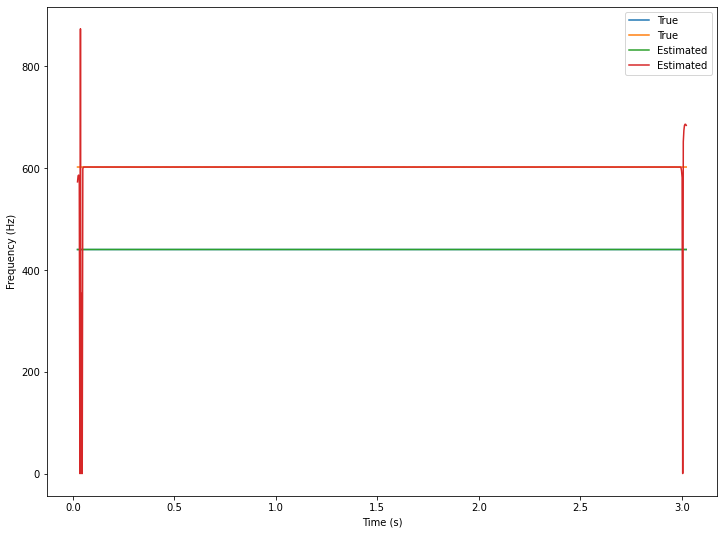

'Explanation\nFor the test case, we can see how the sine with the large amplitude is appropriately tracked, \nhowever the low amplitude sine cannot be tracked all over the duration of the signal. There \nare a lot of discontinuities in the tracking of this sine which can be probably due to a \nconfusion between sidelobes of the spectrum and the actual peak of this low amplitude sine. \nBecause there is a sine with very low amplitude, I selected the Blackman-harris window, since \nthis type of window has the lowest sidelobes. For the magnitude threshold I first computed the \nDFT using sms-tools and Blackman-harris window to check the level of the sidelobes. As I could see, \nthere were two peaks in the magnitude spectrum corresponding to both sines, and the level of \nthe sidelobes was very low. Hence, I selected -80 dB as the magnitude threshold. The results \nshow that there is a bit of confusion of the sinusoidal model in the beginning and end of the\nsignal for the low amplitude si

In [6]:
# E5 - 3.1: First call freq_tracker_error() with the values for the test case and plot the true versus the 
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot 
# the new estimated frequency values. Explain the result.
    
M = 2047                                             # Window size 
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)  
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

### Your code here

# Test case
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window='hanning', t=-80.0, H=H, M=M)      # Track freq values using sinusoidal model with the test case parameters
print("Mean Error: ", meanErr)                                                                            # Print resultant error                                                                   

# Plot true vs. estimated freq values
plt.figure(figsize=(12,9))
plt.plot(tStamps, fTrackTrue, label='True')
plt.plot(tStamps, fTrackEst, label='Estimated')
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

# Select blackman-harris window and threshold of -80 dB
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window='blackmanharris', t=-80, H=H, M=M)   # Track freq values using sinusoidal model
print("Mean Error: ", meanErr)                                                                              # Print resultant mean error

# Plot true vs. estimated freq values
plt.figure(figsize=(12,9))
plt.plot(tStamps, fTrackTrue, label='True')
plt.plot(tStamps, fTrackEst, label='Estimated')
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

"""Explanation
For the test case, we can see how the sine with the large amplitude is appropriately tracked, 
however the low amplitude sine cannot be tracked all over the duration of the signal. There 
are a lot of discontinuities in the tracking of this sine which can be probably due to a 
confusion between sidelobes of the spectrum and the actual peak of this low amplitude sine. 
Because there is a sine with very low amplitude, I selected the Blackman-harris window, since 
this type of window has the lowest sidelobes. For the magnitude threshold I first computed the 
DFT using sms-tools and Blackman-harris window to check the level of the sidelobes. As I could see, 
there were two peaks in the magnitude spectrum corresponding to both sines, and the level of 
the sidelobes was very low. Hence, I selected -80 dB as the magnitude threshold. The results 
show that there is a bit of confusion of the sinusoidal model in the beginning and end of the
signal for the low amplitude sine but apart from that, the estimation is very good since the 
mean frequency error is less than 2 Hz for the two sines.   
"""

## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found. 

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram. 

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


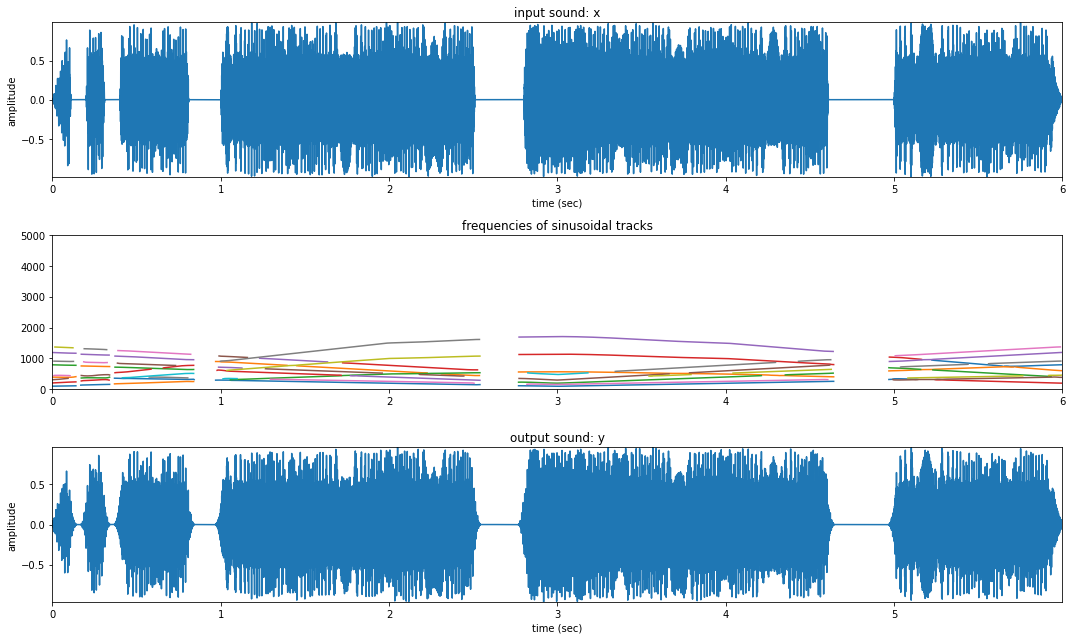

In [7]:
# E5 - 4.1: Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackman'                           # Type of window                   
M = 4411                                      # Window size                             
N = 8192                                      # FFT size                                 
t = -60                                       # Magnitude threshold (dB)                                                
minSineDur = 0.05                             # Minimum sine duration (s)                   
maxnSines = 150                               # Maximum number of sines
freqDevOffset = 20                            # Frequency deviation offset (Hz)
freqDevSlope = 0.001                          # Frequency deviation slope


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)
    
fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')
                
# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [ ]:
# Your explanation of Part 4 here

'''
First, I computed the DFT using the sms-tools in different segments of the signal with the 
default parameters (also using the STFT spectrogram to determine the different segments to 
compute the DFT). I could see the different peaks of the 8 sinusoids (9 in the first onset).
Because there are differences in the amplitudes of the sinusoids, I changed the window type to 
Blackman, since this window has lower sidelobes. In the first two onsets (no chirp yet)
I noticed there were two frequency components which were quite close between them, 
the difference between both peaks was about 60 Hz, so I computed the needed window size 
to discriminate these two peaks using a Blackman window: M = 6*44100/60 = 4410. Of course, since 
there is a chirp effect with cross overs in the next segments of the sound, the window size 
needed to have more frequency resolution during these phases would be very big, however, this 
comes at the expense of less time resolution, which in this case is necessary to handle the 
time varying frequency of the chirps. Therefore, I maintained the previous calculated window 
size for the sinusoidal model. In particular, I put a window size of 4411 (odd value) and the
FFT size to be the next power of 2 (8192). I also adjusted the magnitude threshold to -60 dB,
the minimum duration of sinusoidal track to 0.05 and increased the maximum frequency deviation
to 20 Hz. The resultant analysis shows that the detected sines are quite acceptable, although 
there are some discontinuities in the cross overs as we expected, but the overall analysis 
seems to capture in a quite good way the characteristics of the sound. The synthetized sound 
is practically the same as the original one, however the time resolution could be better, 
since the onsets are a little bit affected. However, because of the challenges associated 
with this complex sound (time varying frequency, cross overs, different amplitudes for the 
sines...), if we want to increase this time resolution and thus make the onsets of the 
synthetized sound more accurate, we would damage the frequency resolution, which for this 
case is especially important. In addition, the affected onsets are not really perceptually 
noticeable, so the set of parameters used here are a good trade-off between frequency and 
time resolution for this particular complex sound.

'''